# Tarea 2
### Integrantes:
- Pablo Araya
- Benjamin Barrientos
- Sebastian Lopez

# P1. Carga y transformación de datos
Al abordar un problema de clasificacióon de imágenes con redes neuronales profundas, es importante optimizar
el proceso de carga de datos. Al tratarse de im´agenes, es de esperar que no todas las muestras puedan ser
almacenadas en memoria de manera simultanea, por lo que es necesario construir un generador. El objetivo de la
sección es construir un generador de muestras eficiente, que minimice el tiempo de carga de datos y optimice el
uso de memoria. 

El conjunto de datos a utilizar esta disponible en este link. En la Figura 1 se observan algunas muestras
de cada clase. La carpeta train consta de alrededor de 5.000 im´agenes y la carpeta test, cerca de 600. Al ser
un conjunto de datos peque˜no, se emplean t´ecnicas de aumentaci´on de datos que ser´an detalladas a continuaci´on.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Se asigna un valor de reproductibilidad
torch.manual_seed(6202)

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

In [ ]:
def loader(path):
    Img = Image.open(path)
    if len(Img.split()) == 1:
        im = Image.merge("RGB", (Img.split()[0], Img.split()[0], Img.split()[0]))
        return im
    else:
        return Img

transformaciones_train = transforms.Compose([transforms.Resize([224,224]),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomRotation(degrees=(-20,20)),
                                       transforms.Lambda(lambda img: img.point(lambda i: i*np.random.uniform(1.2,1.5))),
                                       transforms.ToTensor()])

transformaciones_test = transforms.Compose([transforms.Resize([224,224]),
                                            transforms.ToTensor()])

data_train = datasets.DatasetFolder(root='data\\chest_xray\\train',loader = loader,extensions = ('jpeg'),
                                    transform=transformaciones_train)
data_test = datasets.DatasetFolder(root='data\\chest_xray\\test',loader = loader,extensions = ('jpeg'),
                                   transform=transformaciones_test)

Visualizamos las imágenes de testeo y prueba

In [ ]:
def mostrar_imagenes(m=4, tipo='train'):
    fig, ax = plt.subplots(1, m, figsize=(15, 8))
    for i in range(m):
        if tipo == 'train':
            num = np.random.randint(5233)
            ax[i].imshow(data_train[num][0][1, :])
        if tipo == 'test':
            num = np.random.randint(621)
            ax[i].imshow(data_test[num][0][1, :])
    
        if data_train[num][1] == 0:
            ax[i].title.set_text('NORMAL')
        else:
            ax[i].title.set_text('PNEUMONIA')
                
    plt.tight_layout()
    plt.show()
    return

In [ ]:
mostrar_imagenes(5)

In [ ]:
mostrar_imagenes(5, 'test')

## Parte 2

In [ ]:
pneumonia_train = 0
normal_train = 0
for x in data_train:
    if x[1] == 0:
        normal_train += 1
    else:
        pneumonia_train += 1

In [ ]:
print('TRAIN DATA -', 'NORMAL: {},'.format(normal_train), 'PNEUMONIA: {},'.format(
    pneumonia_train), 'TOTAL: {}'.format(normal_train + pneumonia_train))

In [ ]:
pneumonia_test = 0
normal_test = 0
for x in data_test:
    if x[1] == 0:
        normal_test += 1
    else:
        pneumonia_test += 1

In [ ]:
print('TEST DATA -', 'NORMAL: {}'.format(normal_test),
      'PNEUMONIA: {}'.format(pneumonia_test), 'TOTAL: {}'.format(normal_test + pneumonia_test))

Realizamos visualizaciones

In [ ]:
datos_train = {'TRAIN' : [normal_train, pneumonia_train],
               'TEST' : [normal_test, pneumonia_test]}
index = ['NORMAL', 'PNEUMONIA']

df = pd.DataFrame(datos_train, index = index)

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (20,5))

# Plot
df['TRAIN'].plot(ax = ax[0],color=['C0','C1'], kind='bar', rot=0)
df['TEST'].plot(ax = ax[1],color=['C0','C1'], kind = 'bar', rot=0)
df.plot(ax = ax[2], kind = 'bar',rot=0)

# Títulos
ax[0].title.set_text('TRAIN DATA')
ax[1].title.set_text('TEST DATA')
ax[2].title.set_text('TRAIN & TEST DATA')
plt.show()

## Parte 3

Separamos en conjunto de entrenamiento y validación de 80% y 20% del total de los datos.

In [ ]:
from sklearn.model_selection import train_test_split

X = np.array([np.asarray(obs[0]) for obs in data_train])
y = np.array([obs[1] for obs in data_train])

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = .2)

In [ ]:
class ReplicarMuestreoDePrueba(torch.utils.data.Sampler):
    def __init__(self, etiquetas_prueba, indices_val, etiquetas_val):
        self.etiquetas_prueba = etiquetas_prueba
        self.indices_val = indices_val
        self.etiquetas_val = etiquetas_val
        
    def __iter__(self):
        p_test = np.sum(self.etiquetas_prueba)/len(self.etiquetas_prueba) # prob de ser 1, en testeo
        if p_test < 0.5:
            p_vect = self.etiquetas_val 
        else:
            p_vect = 1 - self.etiquetas_val
        p_vect = p_vect/np.sum(p_vect) # debe sumar 1
        sampleo = self.indices_val
        sampleo_eti = self.etiquetas_val
        p_sampleo = np.sum(sampleo_eti)/len(sampleo_eti)
        while abs(p_sampleo - p_test) > 1e-3:
            index = np.random.choice(self.indices_val, size=1, p=p_vect)
            sampleo = np.append(sampleo, index)
            sampleo_eti = np.append(sampleo_eti, self.etiquetas_val[index])
            p_sampleo = np.sum(sampleo_eti)/len(sampleo_eti)
        return sampleo

parte 4

In [ ]:
from torch.utils.data import DataLoader

# P2. Redes convolucionales profundas

El objetivo de esta secci´on es construir una red neuronal profunda para el problema de clasificaci´on de
im´agenes de rayos X sobre neumon´ıa. Dicha red debe ser implementada en Pytorch.
Se implementa un tipo de capa de convoluci´on conocida como Dephtwise Separable Convolution [2]. Esta
consiste en separar una capa de k filtros de convoluci´on de tama˜no n × n, i.e. definida por k filtros de tama˜no
n × n × c (donde c representa el n´umero de canales) en dos capas de convoluci´on:

In [ ]:
class DWSepConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, bias=True):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                   padding=padding, bias=True) #, groups=in_channels
        
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=True)

    def forward(self, x):
        x = self.depthwise(x)
        out = F.relu(self.pointwise(x))
        return out

In [ ]:
class VGG16DWSep():
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size = 2, stride=2)
        
        self.dwsep1 = DWSepConv2d(64,128,kernel_size = 3, padding = 1)
        self.dwsep2 = DWSepConv2d(128,128,kernel_size = 3, padding = 1)

        self.dwsep3 = DWSepConv2d(128,256,kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(256)
        self.dwsep4 = DWSepConv2d(256,256,kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(256)
        self.dwsep5 = DWSepConv2d(256,256,kernel_size = 3, padding = 1)
        self.mp3 = nn.MaxPool2d(kernel_size = 2, stride=2)
        self.dwsep6 = DWSepConv2d(256,512,kernel_size = 3, padding = 1)
        self.bn3 = nn.BatchNorm2d(512)
        self.dwsep7 = DWSepConv2d(512,512,kernel_size = 3, padding = 1)
        self.bn4 = nn.BatchNorm2d(512)
        self.dwsep8 = DWSepConv2d(512,512,kernel_size = 3, padding = 1)
        
        self.flat = nn.Flatten()
        self.lin1 = nn.Linear(512*49*4,1024)
        self.do1 = nn.Dropout(p=0.7)
        self.lin2 = nn.Linear(1024,512)
        self.do2 = nn.Dropout(p=0.5)
        self.out = nn.Linear(512,2)
        
    def forward(self,x):
        x = x.view(-1,3,224,224)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.dwsep1(x))
        x = F.relu(self.dwsep2(x))
        x = self.pool(x)
        x = F.relu(self.dwsep3(x))
        x = F.relu(self.bn1(x))
        x = F.relu(self.dwsep4(x))
        x = F.relu(self.bn2(x))
        x = F.relu(self.dwsep5(x))
        x = self.pool(x)
        x = F.relu(self.dwsep6(x))
        x = F.relu(self.bn3(x))
        x = F.relu(self.dwsep7(x))
        x = F.relu(self.bn4(x))
        x = F.relu(self.dwsep8(x))
        x = self.pool(x)
        x = self.flat(x)
        x = F.relu(self.lin1(x))
        x = self.do1(x)
        x = F.relu(self.lin2(x))
        x = self.do2(x)
        x = F.relu(self.out(x))
        # x.view(-1, x.size(1))
        return x

In [ ]:
# Testeo 
model = VGG16DWSep()
model.forward(data_train[0][0])

In [ ]:
from torchvision import models
model_vgg16 = models.vgg16(pretrained=True)

In [ ]:
weight_layer1, weight_layer2 = model_vgg16.features[0].weight, model_vgg16.features[2].weight

# Congelamos las capas
weight_layer1.requires_grad, weight_layer2.requires_grad = False, False

In [ ]:
class VGG16DWSep():
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size = 2, stride=2)
        
        #  Capas modificadas
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv1.weight = weight_layer1
        
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv1.weight = weight_layer2
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size = 2, stride=2)
        
        self.dwsep1 = DWSepConv2d(64,128,kernel_size = 3, padding = 1)
        self.dwsep2 = DWSepConv2d(128,128,kernel_size = 3, padding = 1)

        self.dwsep3 = DWSepConv2d(128,256,kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(256)
        self.dwsep4 = DWSepConv2d(256,256,kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(256)
        self.dwsep5 = DWSepConv2d(256,256,kernel_size = 3, padding = 1)
        self.mp3 = nn.MaxPool2d(kernel_size = 2, stride=2)
        self.dwsep6 = DWSepConv2d(256,512,kernel_size = 3, padding = 1)
        self.bn3 = nn.BatchNorm2d(512)
        self.dwsep7 = DWSepConv2d(512,512,kernel_size = 3, padding = 1)
        self.bn4 = nn.BatchNorm2d(512)
        self.dwsep8 = DWSepConv2d(512,512,kernel_size = 3, padding = 1)
        
        self.flat = nn.Flatten()
        self.lin1 = nn.Linear(512*49*4,1024)
        self.do1 = nn.Dropout(p=0.7)
        self.lin2 = nn.Linear(1024,512)
        self.do2 = nn.Dropout(p=0.5)
        self.out = nn.Linear(512,2)
        
    def forward(self,x):
        x = x.view(-1,3,224,224)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.dwsep1(x))
        x = F.relu(self.dwsep2(x))
        x = self.pool(x)
        x = F.relu(self.dwsep3(x))
        x = F.relu(self.bn1(x))
        x = F.relu(self.dwsep4(x))
        x = F.relu(self.bn2(x))
        x = F.relu(self.dwsep5(x))
        x = self.pool(x)
        x = F.relu(self.dwsep6(x))
        x = F.relu(self.bn3(x))
        x = F.relu(self.dwsep7(x))
        x = F.relu(self.bn4(x))
        x = F.relu(self.dwsep8(x))
        x = self.pool(x)
        x = self.flat(x)
        x = F.relu(self.lin1(x))
        x = self.do1(x)
        x = F.relu(self.lin2(x))
        x = self.do2(x)
        x = F.relu(self.out(x))
        return x.view(-1, x.size(1))

In [ ]:
class EarlyStopping():
    def __init__(self, modo='min', paciencia=5, porcentaje=False, tol=0):
        self.modo = modo
        self.paciencia = paciencia
        self.porcentaje = porcentaje
        self.tol = tol
        self.observacion = None
        self.epocas = None

    def mejor(self, metrica_validacion):
        '''
        Retorna True si metrica_validacion es mejor que la observación.
        '''
        if self.observacion is None:
            self.observacion = metrica_validacion
            self.epocas = 1
            return True

        diferencia = metrica_validacion - self.observacion
        cuociente = metrica_validacion/self.observacion

        if modo == 'min':
            if self.porcentaje:
                # Si el cuociente empeoro en 40% = 0.4
                if cuociente < tol:
                    self.epocas = 0
                    return True
                self.epocas += 1
                return False
            else:
                # Si la metrica es mejor..
                if diferencia < tol:
                    self.epocas = 0
                    return True
                self.epocas += 1
                return False

        else:  # if modo == 'max'
            if self.porcentaje:
                if cuociente > 1+tol:
                    self.epocas = 0
                    return True
                self.epocas += 1
                return False
            else:
                if diferencia > tol:
                    self.epocas = 0
                    return True
                self.epocas += 1
                return False

    def deberia_parar(self, metrica_validacion):
        # Si estoy al límite y no mejoré
        if self.epocas == self.paciencia and not mejor(self, metrica_validacion):
            return True
        return False

In [ ]:
def train(epochs, model, loss_func, optimizer, train_dl, valid_dl):
    instancia = EarlyStopping()
    f1_score = []
    accuracy = []
    
    print('Cambiando a GPU...')
    model.cuda()
    print('... Done')

    for epoch in range(epochs):
        train_loss = 0.0
        target_true = 0.0
        predicted_true = 0.0
        correct_true = 0.0
        f1 = 0.0
        
        print('Empezamos el entrenamiento...')
        #ciclo de entrenamiento
        for i, (data, target) in enumerate(train_dl):
            # Pasamos a GPU
            data, target = data.cuda(), target.long().cuda()
            
            # Limpiamos los gradientes
            optimizer.zero_grad()
                
            output = model(data)

             # Loss and backpropagation of gradients
            loss = loss_func(output.cuda(), target)
            loss.backward()
            #update parameters
            optimizer.step()

            train_loss += loss.item() * data.size(0)

            # F1-score
            #predicted_classes = torch.argmax(output, dim=1) == 0
            #target_classes = target.argmax()
            #target_true += torch.sum(target_classes == 0).float()
            #predicted_true += torch.sum(predicted_classes).float()
            #correct_true += torch.sum(
            #    predicted_classes == (target_classes * predicted_classes == target_classes)).float()

        print('Ciclo de validación...')
        # Validación
        correct = 0
        total = 0
        for i, (data, target) in enumerate(valid_dl):
            data, target = data.cuda(), target.cuda()
            outputs = model(data)
            correct += (torch.argmax(outputs, dim=1) == target).float().sum()
            total += len(target)
    
        metrica_validacion = 100 * correct / total
        metrica_validacion = metrica_validacion.item()
        accuracy.append(metrica_validacion)
        
        #recall = correct_true / target_true
        #precision = correct_true / predicted_true
        #f1 = 2 * precision * recall / (precision + recall)
        #f1_score.append(f1)

        print('Epoca: ', epoch, ', Validation accuracy: ', metrica_validacion, ", Training loss: ", train_loss, ", F1-score", f1)
        
        if instancia.deberia_parar(metrica_validacion):
            break
        
    return f1_score, accuracy, model

In [ ]:
from torch import optim
epochs = 20
model = VGG16DWSep()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
loss_func = F.cross_entropy
f1_score, accuracy, modelo = train(epochs, model, loss_func, optimizer, train_dl, valid_dl)

In [ ]:
import pickle as pkl
#aqui carga modelo
modelo =

In [ ]:
for i, (data, target) in enumerate(valid_dl):
  data = data.cuda()
  out = modelo(data)
  print(torch.argmax(out, dim=1))
  break

# P3 Interpretabilidad

## 1.

In [1]:
import torch
from torchvision import transforms

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

#Define la transformación de datos pedida
data_transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [2]:
dev

device(type='cuda')

## 2.

In [3]:
from PIL import Image

#Carga la imagen de control
control_img = Image.open('llama.jpeg')

In [ ]:
import torchvision
#Carga red inception_v3
inception = torchvision.models.inception_v3(pretrained=True)
inception.to(device=dev)
inception.eval()

In [5]:
#Obtiene la prediccion de inception sobre la img de control
from keras.applications.imagenet_utils import decode_predictions
import numpy as np

trans_img = data_transform(control_img).unsqueeze(0)

with torch.no_grad():
    pred_control = inception(trans_img.to(dev))
    
pred_control = decode_predictions(pred_control.cpu().detach().numpy(), top=1)
pred_control

Using TensorFlow backend.


[[('n02437616', 'llama', 9.439323)]]

## 3.

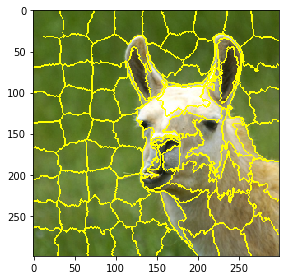

In [6]:
from skimage.segmentation import slic, mark_boundaries
from skimage.io import imshow

parches = 80
half_transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299)
])

halftrans_img = half_transform(control_img)
segments = slic(halftrans_img, n_segments=parches)
imshow(mark_boundaries(halftrans_img, segments))

## 4.

In [7]:
import scipy.stats as stats

n_perturbaciones = 1000
perturbaciones = [stats.bernoulli.rvs(0.5, size=parches) for i in range(n_perturbaciones)]   

In [8]:
perturbaciones[0]

array([1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1])

## 5.

In [9]:
def pert_img_fixed_clusters(clusters): 
  def perturbar_img(perturbacion, segments=clusters, img=halftrans_img):
      img_perturbada = transforms.ToTensor()(img)
      #img_perturbada = mark_boundaries(img, segments)
      
      for k,booleano in enumerate(perturbacion):
          mask = (segments == k+1)
          mask = 1-mask
          if not booleano:
              for dim in range(3):
                  img_perturbada[dim,:,:] *= mask
              
      img_perturbada = transforms.ToPILImage()(img_perturbada)
              
      return img_perturbada
    
  return perturbar_img

perturbar_img = pert_img_fixed_clusters(segments)
imgs_perturbadas = list(map(perturbar_img, perturbaciones))

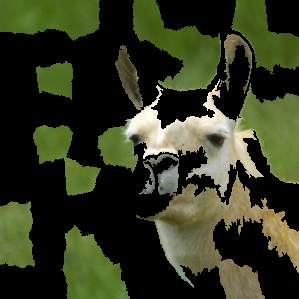

In [10]:
imgs_perturbadas[0]

## 6.

In [11]:
from torch.utils.data import DataLoader
import torch

secondhalf_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

trans_pert_imgs = list(map(secondhalf_transform,imgs_perturbadas))

preds = []

with torch.no_grad():
    inception.eval()
    for i,img in enumerate(trans_pert_imgs):
        img = img.type(torch.float32).unsqueeze(0)
        pred = inception(img.to(dev))
        pred = decode_predictions(pred.cpu().detach().numpy(), top=1)
        preds.append(pred)

y = []
for pred in preds:
  if pred[0][0][1] == pred_control[0][0][1]:
    y.append(1)
  else:
    y.append(0)

In [12]:
preds

[[[('n12985857', 'coral_fungus', 6.766507)]],
 [[('n12985857', 'coral_fungus', 7.4242992)]],
 [[('n12985857', 'coral_fungus', 4.8664846)]],
 [[('n12985857', 'coral_fungus', 6.1263847)]],
 [[('n02328150', 'Angora', 4.6520805)]],
 [[('n01518878', 'ostrich', 4.512757)]],
 [[('n12985857', 'coral_fungus', 8.549056)]],
 [[('n01518878', 'ostrich', 8.328642)]],
 [[('n12985857', 'coral_fungus', 7.439787)]],
 [[('n02437616', 'llama', 9.688843)]],
 [[('n02437616', 'llama', 6.0531297)]],
 [[('n12985857', 'coral_fungus', 7.5169587)]],
 [[('n02437616', 'llama', 8.025889)]],
 [[('n12985857', 'coral_fungus', 8.176954)]],
 [[('n01518878', 'ostrich', 8.313659)]],
 [[('n01518878', 'ostrich', 3.98804)]],
 [[('n01616318', 'vulture', 5.0963483)]],
 [[('n02437616', 'llama', 9.7696495)]],
 [[('n02437616', 'llama', 7.7224026)]],
 [[('n12985857', 'coral_fungus', 6.228899)]],
 [[('n02500267', 'indri', 5.827507)]],
 [[('n01616318', 'vulture', 5.09035)]],
 [[('n02500267', 'indri', 6.2413244)]],
 [[('n12985857', 'c

In [13]:
y

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,


## 7.

In [14]:
def dist_cos(x_hat,z_hat):
    return 1 - (np.dot(x_hat,z_hat)/(np.linalg.norm(x_hat)*np.linalg.norm(z_hat)))

def pi_x(z_hat, n, sigma=0.25):
    x_hat = np.ones(n)
    return np.exp(-(dist_cos(x_hat,z_hat)**2)/sigma**2)


pesos_perts = [pi_x(pert,80) for pert in perturbaciones]

In [15]:
pesos_perts

[0.19443697857784792,
 0.12904064146322683,
 0.367879441171442,
 0.3436385704325335,
 0.09034839216461878,
 0.3436385704325335,
 0.17662129479527383,
 0.297067110003447,
 0.17662129479527383,
 0.46952269069991975,
 0.3436385704325335,
 0.2132005521961349,
 0.25345144771897427,
 0.27486195236433913,
 0.2132005521961349,
 0.1597748708958631,
 0.25345144771897427,
 0.44356692607695714,
 0.3436385704325335,
 0.2132005521961349,
 0.19443697857784792,
 0.17662129479527383,
 0.1597748708958631,
 0.27486195236433913,
 0.32001265976166365,
 0.41792033397820694,
 0.23288373765503725,
 0.39266494851960243,
 0.44356692607695714,
 0.46952269069991975,
 0.17662129479527383,
 0.297067110003447,
 0.1597748708958631,
 0.1597748708958631,
 0.32001265976166365,
 0.3436385704325335,
 0.17662129479527383,
 0.23288373765503725,
 0.25345144771897427,
 0.3436385704325335,
 0.32001265976166365,
 0.2132005521961349,
 0.1597748708958631,
 0.41792033397820694,
 0.2132005521961349,
 0.297067110003447,
 0.343638570

## 8.

In [16]:
Dp = (perturbaciones, y)

## 9.

In [17]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(Dp[0],
       Dp[1],
       sample_weight=pesos_perts
      )

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

No se divide en train y test, puesto que nos interesa ver que pesos importan al momento de calificar nuestras imágenes. Para ello, es mejor entrenar con todos los datos, así no perdemos información.\\
Notemos que bajo este esquema, dado que el método fit no pérmite agregar sumandos, solo permite agregar un factor con el parámetro sample_weights, no es posible agregar la medida de complejidad.

## 10.

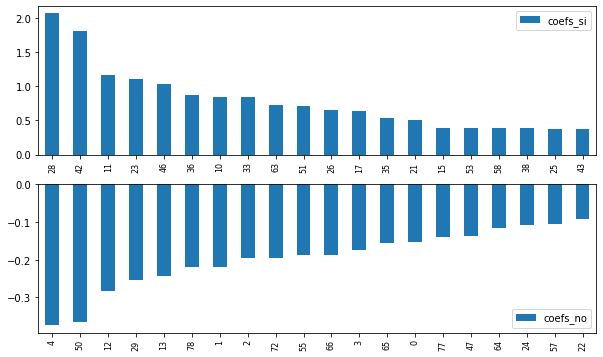

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

coefs = lr.coef_[0]
#Pixeles SI
idx_coefs_si = np.argsort(coefs)[::-1]
coefs_si = np.sort(coefs)[::-1]
df_coefs_si = pd.DataFrame({'coefs_si':coefs_si},index=idx_coefs_si)

#Pixeles NO
idx_coefs_no = np.argsort(coefs)
coefs_no = np.sort(coefs)
df_coefs_no = pd.DataFrame({'coefs_no':coefs_no},index=idx_coefs_no)

#Plots
fig, ax = plt.subplots(2,1,figsize=(10,6))
ax[0].tick_params(axis='x', labelsize=8)
df_coefs_si.nlargest(int(len(coefs_si)/4), 'coefs_si').plot(kind = 'bar', ax=ax[0])

ax[1].tick_params(axis='x', labelsize=8)
df_coefs_no.nsmallest(int(len(coefs_no)/4), 'coefs_no').plot(kind = 'bar', ax=ax[1])

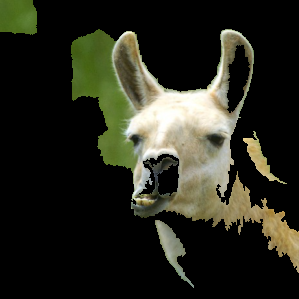

In [19]:
idx_si = idx_coefs_si[:int(len(coefs_si)/4)]
si_pixels = np.zeros(parches)
si_pixels[idx_si] = 1
visual = perturbar_img(si_pixels)
visual

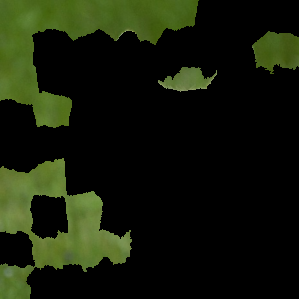

In [20]:
idx_no = idx_coefs_no[:int(len(coefs_si)/4)]
no_pixels = np.zeros(parches)
no_pixels[idx_no] = 1
visual = perturbar_img(no_pixels)
visual

## 11.

In [21]:
original_img = half_transform(control_img)
original_img = original_img.convert('L')
original_img = np.array(original_img)

n,m = original_img.shape
X = np.array([(i,j,original_img[i,j]) for i in range(n) for j in range(m)])

### Clustering por KNN

In [222]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=80)
clusters_km = km.fit_predict(X)
clusters_km = clusters_km.reshape(299,299)

In [223]:
clusters_km

array([[14, 14, 14, ..., 42, 42, 42],
       [14, 14, 14, ..., 42, 42, 42],
       [14, 14, 14, ..., 42, 42, 42],
       ...,
       [31, 31, 31, ..., 37, 37, 37],
       [31, 31, 31, ..., 37, 37, 37],
       [31, 31, 31, ..., 37, 37, 37]], dtype=int32)

In [224]:
np.unique(clusters_km)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79], dtype=int32)

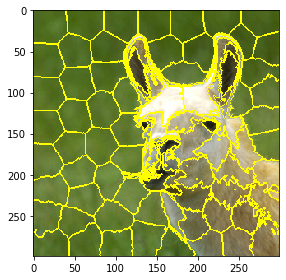

In [225]:
imshow(mark_boundaries(halftrans_img, clusters_km))

### Clutering por Gaussian Mixture

In [26]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=80)
clusters_gmm = gmm.fit_predict(X)
clusters_gmm = clusters_gmm.reshape(299,299)

In [27]:
clusters_gmm

array([[47, 47, 47, ..., 28, 28, 28],
       [47, 47, 47, ..., 28, 28, 28],
       [47, 47, 47, ..., 28, 28, 28],
       ...,
       [26, 26, 26, ...,  7,  7,  7],
       [26, 26, 26, ..., 38,  7,  7],
       [26, 26, 26, ..., 38,  7,  7]])

In [28]:
np.unique(clusters_gmm)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79])

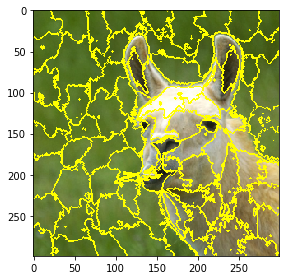

In [29]:
imshow(mark_boundaries(halftrans_img, clusters_gmm))

## 12.

In [30]:
def LIME(clusters, img=halftrans_img, n_perturbaciones=n_perturbaciones):
  n_clusters = len(np.unique(clusters))
  perturbaciones = [stats.bernoulli.rvs(0.5, size=n_clusters) for i in range(n_perturbaciones)]

  perturbar_img = pert_img_fixed_clusters(clusters)
  imgs_perturbadas = list(map(perturbar_img, perturbaciones))

  secondhalf_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

  trans_pert_imgs = list(map(secondhalf_transform,imgs_perturbadas))

  preds = []

  with torch.no_grad():
    inception.eval()
    for i,img in enumerate(trans_pert_imgs):
      img = img.type(torch.float32).unsqueeze(0)
      pred = inception(img.to(dev))
      pred = decode_predictions(pred.cpu().detach().numpy(), top=1)
      preds.append(pred)

  y = []
  for pred in preds:
    if pred[0][0][1] == pred_control[0][0][1]:
      y.append(1)
    else:
      y.append(0)

  pesos_perts = [pi_x(pert,n_clusters) for pert in perturbaciones]
  Dp = (perturbaciones, y)

  lr = LogisticRegression()
  lr.fit(Dp[0],
       Dp[1],
       sample_weight=pesos_perts
      )
  
  coefs = lr.coef_[0]
  #Pixeles SI
  idx_coefs_si = np.argsort(coefs)[::-1]
  coefs_si = np.sort(coefs)[::-1]

  idx_si = idx_coefs_si[:int(len(coefs_si)/4)]
  si_pixels = np.zeros(n_clusters)
  si_pixels[idx_si] = 1
  visual = perturbar_img(si_pixels)

  return visual

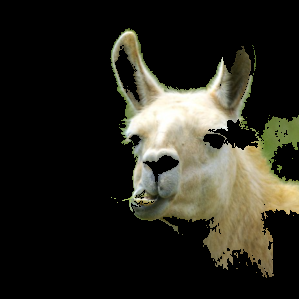

In [31]:
img_gmm = LIME(clusters_gmm)
img_gmm

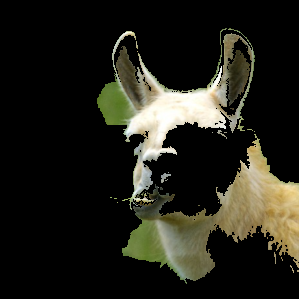

In [227]:
img_km = LIME(clusters_km)
img_km